In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'gender_submission.csv', 'test.csv']


In [3]:
url_train = '../input/train.csv'
titanic = pd.read_csv(url_train)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
#Checking if our target variable is binary or not
#sb.countplot(x='Survived',data=titanic)

In [4]:
#Checking Null values
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Dropping PassengerId, Name and Ticket because they are unique.
Dropping Cabin because of too many null values.

In [5]:
titanic_data = titanic.drop(['PassengerId','Name','Ticket'],1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


Now need to take care of the missing data for Age variable. Need to approximate- one way, to take mean age for all the missing values.
Or, find if age is related to Pclass, and assign respective means.

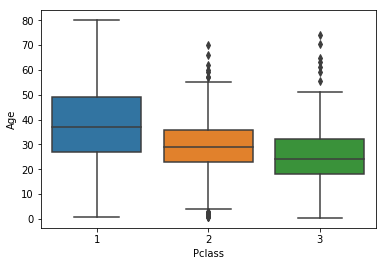

In [6]:
sb.boxplot(x='Pclass',y='Age',data=titanic_data)

If Passenger belongs to Pclass 3, age assigned is 24, if 2, age is assigned 29, if 1 then 37.

In [7]:
def age_approx(cols):
    age = cols[0]
    pclass = cols[1]
    if pd.isnull(age):
        if pclass == 1:
            return 37
        elif pclass == 2:
            return 29
        else:
            return 24
    else:
        return age

In [8]:
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [9]:
def cabin_approx(cols):
    cabin = cols[0]
    pclass = cols[1]
    if pd.isnull(cabin):
        return 0
    elif cabin[0] == ('C' or 'B'):
        return 3
    elif cabin[0] == ('A' or 'D' or 'E' or 'T'):
        return 2
    elif cabin[0] == ('F' or 'G'):
        return 1
    else:
        return 0

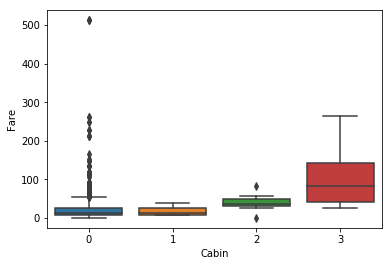

In [10]:
titanic_data['Cabin'] = titanic_data[['Cabin', 'Pclass']].apply(cabin_approx, axis=1)
#titanic_data.isnull().sum()
sb.boxplot(x='Cabin',y='Fare',data=titanic_data)

There are two null values in Embarked, we can just drop them.

In [11]:
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

Getting dummy variables from categorical ones.

In [12]:
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [13]:
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
embark_location.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [14]:
titanic_data.drop(['Sex','Embarked'],axis=1,inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin
0,0,3,22.0,1,0,7.2500,0
1,1,1,38.0,1,0,71.2833,3
2,1,3,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,3
4,0,3,35.0,0,0,8.0500,0


In [15]:
titanic_dmy = pd.concat([titanic_data, gender, embark_location],axis=1)
titanic_dmy.tail()

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,male,Q,S
886,0,2,27.0,0,0,13.00,0,1,0,1
887,1,1,19.0,0,0,30.00,0,0,0,1
888,0,3,24.0,1,2,23.45,0,0,0,1
889,1,1,26.0,0,0,30.00,3,1,0,0
890,0,3,32.0,0,0,7.75,0,1,1,0


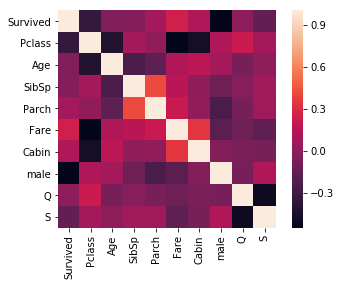

In [16]:
#Checking for correlation between variables.
sb.heatmap(titanic_dmy.corr(),square=True)
#print(titanic_dmy.corr())

In [17]:
X = titanic_dmy.ix[:,(1,2,3,4,5,6,7,8,9)].values
y = titanic_dmy.ix[:,0].values
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
 

The train test split is done for parameter tuning.
We now deploy the models.

In [18]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier

clf1 = SVC(kernel='linear',C=1.0,random_state=3)
clf2 = XGBClassifier(random_state=3)
clf3 = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=300)
eclf = VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2),('clf3',clf3)], voting='hard')

eclf.fit(X_train, y_train)
y_pred = eclf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(eclf.score(X_test, y_test))

[[47  5]
 [11 26]]
0.8202247191011236


**Now taking in Competition Data.**

In [19]:
url = '../input/test.csv'
test = pd.read_csv(url)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [20]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

There are 86 null values in Age, so we approximate them like we did earlier.
There are 327 null values in Cabin, so we drop it altogether.
There is 1 null value in Fare, so we approximate it according to the median of each class of the null position.

In [21]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


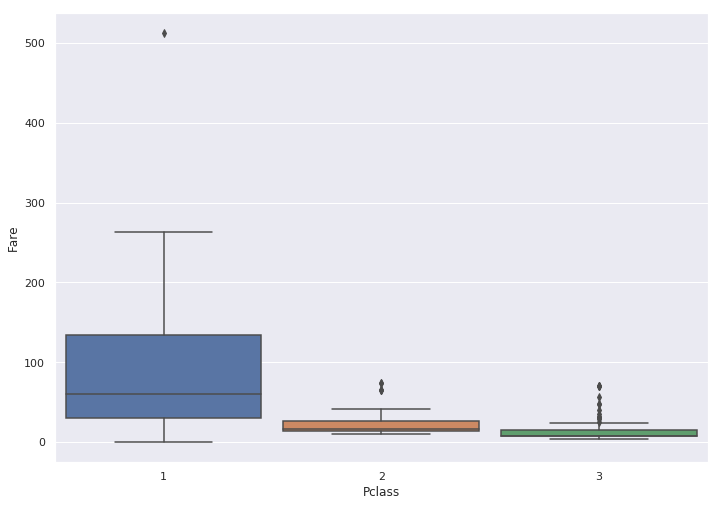

In [22]:
sb.set(rc={'figure.figsize':(11.7,8.27)})
ax = sb.boxplot(x='Pclass',y='Fare',data=test,width=0.9)

In [23]:
def fare_approx(cols):
    fare = cols[0]
    pclass = cols[1]
    if pd.isnull(fare):
        if pclass == 1:
            return 55
        elif pclass == 2:
            return 20
        else:
            return 10
    else:
        return fare

**Cleaning up the test data:**
Dropping variables, approximating age and fare, dummy variables.

In [24]:
test_data = test.drop(['Name','Ticket'],1)
test_data['Age'] = test_data[['Age', 'Pclass']].apply(age_approx, axis=1)
test_data['Fare'] = test_data[['Fare','Pclass']].apply(fare_approx, axis=1)
test_data['Cabin'] = test_data[['Cabin','Pclass']].apply(cabin_approx, axis=1)
#
gender_test = pd.get_dummies(test_data['Sex'],drop_first=True)
embark_location_test = pd.get_dummies(test_data['Embarked'],drop_first=True)
test_data.drop(['Sex','Embarked'],axis=1,inplace=True)
test_dmy = pd.concat([test_data, gender_test, embark_location_test],axis=1)

#test_dmy.describe()
test_data.dropna(inplace=True)
test_dmy.isnull().sum()

PassengerId    0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
male           0
Q              0
S              0
dtype: int64

In [25]:
test_dmy.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Cabin,male,Q,S
0,892,3,34.5,0,0,7.8292,0,1,1,0
1,893,3,47.0,1,0,7.0000,0,0,0,1
2,894,2,62.0,0,0,9.6875,0,1,1,0
3,895,3,27.0,0,0,8.6625,0,1,0,1
4,896,3,22.0,1,1,12.2875,0,0,0,1


In [26]:
X_competition = test_dmy.ix[:,(1,2,3,4,5,6,7,8,9)].values

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


**Prediction for Competition Data**

In [27]:
y_comp = eclf.predict(X_competition)

In [28]:
submission = pd.DataFrame({'PassengerId':test_data['PassengerId'],'Survived':y_comp})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [ ]:
filename = 'Titanic Predictions 1.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)